In [ ]:
import pandas as pd

df1=pd.read_csv("Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE4_1_PeptideGroups.txt", sep="\t")
df2=pd.read_csv("Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE4_2_PeptideGroups.txt", sep="\t")
OUTPUT_FILE=    "Ascend_VQneo_ES75500_FAIMS_MS2_COOKIE4_merged.tsv"

time=3600 # 1h=3600s
df1.head()

,Checked,Confidence,Annotated Sequence,Modifications,# Protein Groups,# Proteins,# PSMs,Master Protein Accessions,Positions in Master Proteins,Modifications in Master Proteins,...,"Found in Sample: F7: 126, Sample, n/a, n/a, DMSO","Found in Sample: F7: 135N, Sample, n/a, n/a, DMSO",PSM Confidence (by Search Engine): Sequest HT,PSM q-Value (by Search Engine): Sequest HT,PSM PEP (by Search Engine): Sequest HT,PSM SVM Score (by Search Engine): Sequest HT,PSM XCorr (by Search Engine): Sequest HT,PEP,q-Value,Channel Occupancy [%]
0,False,High,[RK].DHCVAHK.[L],1xTMTpro [N-Term]; 1xDBIA [C3]; 1xTMTpro [K7],1,2,1,A0A096LP55,A0A096LP55 [79-85],NaN,...,High,High,High,0.001650,2.941040e-02,0.180139,1.97,3.462790e-02,0.001755,94
1,False,High,[K].GQVCLPVISAENWKPATK.[T],1xTMTpro [N-Term]; 1xDBIA [C4]; 2xTMTpro [K14;...,1,2,1,A0A1B0GUS4,A0A1B0GUS4 [83-100],NaN,...,High,High,High,0.000149,9.438770e-05,0.851815,4.74,1.164180e-04,0.000163,94
2,False,High,[R].LCYNPK.[G],1xTMTpro [N-Term]; 1xDBIA [C2]; 1xTMTpro [K6],1,1,1,A0A1W2PPD8,A0A1W2PPD8 [390-395],NaN,...,High,High,High,0.002613,5.631810e-02,0.100528,1.98,6.571530e-02,0.002698,100
3,False,High,[K].ESVSNCIQLK.[T],1xTMTpro [N-Term]; 1xDBIA [C6]; 1xTMTpro [K10],1,1,1,A0A3B3IRV3,A0A3B3IRV3 [9-18],NaN,...,High,High,High,0.000316,2.148900e-03,0.488133,2.52,2.591660e-03,0.000351,94
4,False,High,[R].ADHQPLTEASYVNLPTIALCNTDSPLR.[Y],1xTMTpro [N-Term]; 1xDBIA [C20],1,2,1,A0A8I5KQE6,A0A8I5KQE6 [129-155],NaN,...,High,High,High,0.000149,3.308590e-08,1.776910,8.11,4.315720e-08,0.000163,100


In [77]:
import re
from collections import defaultdict
import pandas as pd # For example usage

def parse_annotated_sequence(annot_seq_str: str) -> str:
    """
    Extracts the core peptide sequence from the 'Annotated Sequence' string.
    Example: "[K].VLQCHKPVHAEYLEK.[L]" -> "VLQCHKPVHAEYLEK"
    Handles formats like [K].PEPTIDE.[L], [RK].PEPTIDE.[L], or [-].PEPTIDE.[L]
    """
    parts = annot_seq_str.split('.')
    if len(parts) == 3:
        # This is a simple fallback; primary regex is preferred for consistency.
        # print(f"Warning: Using fallback peptide parsing for: {annot_seq_str}")
        return parts[1]
        
    raise ValueError(f"Cannot parse peptide from Annotated Sequence: {annot_seq_str}")

def parse_positions_in_master_proteins(pos_str: str) -> tuple[int, str]:
    """
    Extracts the start position and the full position string.
    Example: "A0A024RBG1 [129-143]" -> (129, "A0A024RBG1 [129-143]")
    """
    match = re.search(r"\[(\d+)-(\d+)\]", pos_str)
    if match:
        start_pos = int(match.group(1))
        # The full string is used for the 'peptide' key in the output dict
        return start_pos, pos_str
    raise ValueError(f"Cannot parse start position from: {pos_str}")

def process_row_updated(row: pd.Series) -> dict:
    peptide_sequence = parse_annotated_sequence(row['Annotated Sequence'])
    start_pos, peptide_key_val = parse_positions_in_master_proteins(row['Positions in Master Proteins'])
    
    modifications_str = str(row['Modifications'])
    parsed_mod_details = {}

    # CORRECTED LINE: Use re.split for more robust outer splitting
    # This splits by a semicolon followed by zero or more whitespace characters.
    individual_mods = re.split(r';?\s*\d+x', modifications_str) #match "; 1x"
    for mod_entry in individual_mods:
        mod_entry_stripped = mod_entry.strip()
        if not mod_entry_stripped:
            continue
            
        mod_match = re.match(r"([a-zA-Z0-9_\-+]+)\s*\[(.*?)\]", mod_entry_stripped)
        mod_type = mod_match.group(1)
        mod_details_str = mod_match.group(2).strip()

        if mod_type not in parsed_mod_details:
            parsed_mod_details[mod_type] = []
        
        current_mod_positions_for_this_entry = []

        if mod_details_str.upper() == "N-TERM":
            abs_pos = start_pos + (1 - 1)
            current_mod_positions_for_this_entry.append(abs_pos)
        else:
            # This inner split for details like [K6; K15] was already robust
            site_descriptors = re.split(r';\s*', mod_details_str)
            for site_desc in site_descriptors:
                site_desc_stripped = site_desc.strip()
                if not site_desc_stripped: continue

                site_match = re.match(r"([A-Z])?(\d+)", site_desc_stripped)
                if site_match:
                    peptide_index = int(site_match.group(2))
                    if not (0 < peptide_index <= len(peptide_sequence)):
                        # print(f"Warning: Peptide index {peptide_index} for mod '{mod_type}' on site '{site_desc_stripped}' is out of bounds for peptide '{peptide_sequence}' (length {len(peptide_sequence)}). Skipping this site.")
                        continue
                    abs_pos = start_pos + (peptide_index - 1)
                    current_mod_positions_for_this_entry.append(abs_pos)
        if current_mod_positions_for_this_entry:
            parsed_mod_details[mod_type].extend(current_mod_positions_for_this_entry)

    result_dict = {'peptide': peptide_key_val}
    for mod_type, positions in parsed_mod_details.items():
        result_dict[mod_type] = sorted(list(set(positions))) if positions else []

    if 'DBIA' not in result_dict:
        result_dict['DBIA'] = []
    if 'TMTpro' not in result_dict:
        result_dict['TMTpro'] = []
    
    print(result_dict)
    return result_dict



def parse_peptide_from_annotated_sequence(annot_seq_str: str) -> str:
    """
    Extracts the core peptide sequence from the 'Annotated Sequence' string.
    Expected format example: "[K].VLQCHKPVHAEYLEK.[L]"
    """
    match = re.match(r"\[[A-Z-]{1,2}\]\.([A-Z]+)\.\[[A-Z-]\]", annot_seq_str)
    if match:
        return match.group(1)
    else:
        parts = annot_seq_str.split('.')
        if len(parts) == 3:
            return parts[1]
    raise ValueError(f"Cannot parse peptide from 'Annotated Sequence': '{annot_seq_str}' using known patterns.")

def generate_formatted_peptide_identifier(annotated_sequence_str: str, modifications_str: str) -> str:
    if pd.isna(annotated_sequence_str) or not annotated_sequence_str:
        return ""
    
    try:
        peptide_sequence = parse_peptide_from_annotated_sequence(annotated_sequence_str)
    except ValueError as e:
        return f"ErrorParsingPeptide: {annotated_sequence_str}"

    if pd.isna(modifications_str) or not modifications_str:
        return peptide_sequence # Return raw peptide if no modifications string

    if not peptide_sequence:
        return ""

    parsed_mod_applications = [] 

    # --- MODIFIED PART: Using re.findall() for outer segmentation ---
    # This pattern defines what one full modification entry looks like.
    # It has no capturing groups here, so findall returns a list of strings (the full entries).
    single_full_entry_pattern = r"\d+x\s*[a-zA-Z0-9_+-]+\s*\[.*?\]"
    individual_mod_entries = re.findall(single_full_entry_pattern, modifications_str)
    # --- End of MODIFIED PART ---

    for entry_stripped in individual_mod_entries: # entry_stripped is now a full "Nx ModName [Details]"
        # This pattern is for deconstructing the already isolated entry.
        # It HAS capturing groups to get the base name and details.
        # Group 1: Nx prefix (e.g., "1x ")
        # Group 2: Base modification name (e.g., "TMTpro")
        # Group 3: Details in brackets (e.g., "N-Term", "C4", "K6; K15")
        deconstruct_pattern = r"(\d+x\s*)([a-zA-Z0-9_+-]+)\s*\[(.*?)\]"
        mod_entry_match = re.match(deconstruct_pattern, entry_stripped)

        if not mod_entry_match:
            # This should ideally not happen if findall worked correctly with a matching pattern.
            # print(f"Warning: Found entry '{entry_stripped}' could not be deconstructed.")
            continue
        
        mod_base_name = mod_entry_match.group(2)
        details_str = mod_entry_match.group(3).strip()
        mod_tag_to_insert = f"[{mod_base_name}]"

        if details_str.upper() == "N-TERM":
            if len(peptide_sequence) > 0:
                 parsed_mod_applications.append((0, mod_tag_to_insert))
        else:
            site_descriptors = re.split(r';\s*', details_str) # This splits "K6; K15"
            for site_desc in site_descriptors:
                site_desc_stripped = site_desc.strip()
                if not site_desc_stripped: continue

                site_match = re.match(r"([A-Z])?(\d+)", site_desc_stripped)
                if site_match:
                    specified_residue_char = site_match.group(1)
                    position_1_based = int(site_match.group(2))
                    peptide_0_based_idx = position_1_based - 1

                    if not (0 <= peptide_0_based_idx < len(peptide_sequence)):
                        # print(f"Warning: Position {position_1_based} ('{site_desc_stripped}') for mod '{mod_base_name}' is out of bounds for peptide '{peptide_sequence}'.")
                        continue
                    
                    if specified_residue_char:
                        actual_residue = peptide_sequence[peptide_0_based_idx]
                        if actual_residue.upper() != specified_residue_char.upper():
                            # print(f"Warning: Residue mismatch for '{site_desc_stripped}'. Mod '{mod_base_name}' for '{specified_residue_char}', found '{actual_residue}'. Mod placed anyway.")
                            pass 
                    
                    parsed_mod_applications.append((peptide_0_based_idx, mod_tag_to_insert))

    if not parsed_mod_applications:
        return peptide_sequence

    mods_at_peptide_index = defaultdict(list)
    for rel_idx, mod_tag in parsed_mod_applications:
        mods_at_peptide_index[rel_idx].append(mod_tag)

    insertions = []
    for rel_idx, tags_list in mods_at_peptide_index.items():
        if tags_list:
            tags_list.sort() 
            combined_tags_str = "".join(tags_list)
            insertions.append((rel_idx, combined_tags_str))

    insertions.sort(key=lambda x: x[0], reverse=True)

    seq_char_list = list(peptide_sequence)
    for rel_idx, combined_tags_str_to_insert in insertions:
        seq_char_list.insert(rel_idx + 1, combined_tags_str_to_insert)
        
    return "".join(seq_char_list)


In [78]:
# Apply the updated function to each row to create the new 'index' column
df1['dict'] = df1.apply(process_row_updated, axis=1)
print([index for index in df1["dict"]])

df1['Formatted_Peptide_ID'] = df1.apply(lambda row: generate_formatted_peptide_identifier(row['Annotated Sequence'], row['Modifications']),axis=1)
df1.set_index('Formatted_Peptide_ID', inplace=True)

# Apply the updated function to each row to create the new 'index' column
df2['dict'] = df2.apply(process_row_updated, axis=1)
print([index for index in df2["dict"]])

df2['Formatted_Peptide_ID'] = df2.apply(lambda row: generate_formatted_peptide_identifier(row['Annotated Sequence'], row['Modifications']),axis=1)
df2.set_index('Formatted_Peptide_ID', inplace=True)

df2.to_csv("temp.tsv", sep="\t")

{'peptide': 'A0A096LP55 [79-85]', 'TMTpro': [79, 85], 'DBIA': [81]}
{'peptide': 'A0A1B0GUS4 [83-100]', 'TMTpro': [83, 96, 100], 'DBIA': [86]}
{'peptide': 'A0A1W2PPD8 [390-395]', 'TMTpro': [390, 395], 'DBIA': [391]}
{'peptide': 'A0A3B3IRV3 [9-18]', 'TMTpro': [9, 18], 'DBIA': [14]}
{'peptide': 'A0A8I5KQE6 [129-155]', 'TMTpro': [129], 'DBIA': [148]}
{'peptide': 'A0A8I5KQE6 [156-166]', 'TMTpro': [156, 166], 'DBIA': [163]}
{'peptide': 'A0AV96 [141-152]', 'TMTpro': [141], 'DBIA': [145], 'Carbamidomethyl': [146, 151]}
{'peptide': 'A0AV96 [141-152]', 'TMTpro': [141], 'DBIA': [145, 146], 'Carbamidomethyl': [151]}
{'peptide': 'A0AVF1 [226-231]', 'TMTpro': [226], 'DBIA': [227]}
{'peptide': 'A0AVT1 [170-175]', 'TMTpro': [170], 'DBIA': [174]}
{'peptide': 'A0AVT1 [176-182]', 'TMTpro': [176, 182], 'DBIA': [178]}
{'peptide': 'A0AVT1 [342-356]', 'TMTpro': [342, 356], 'DBIA': [347]}
{'peptide': 'A0AVT1 [448-457]', 'TMTpro': [448, 457], 'Carbamidomethyl': [], 'DBIA': []}
{'peptide': 'A0AVT1 [715-727]', '

In [79]:
import pandas as pd
import numpy as np # Used for np.nan in sample data creation


# 1. Rename columns
df1_renamed = df1.copy()
df1_renamed.columns = [f"{col}_rep1" for col in df1.columns]
df2_renamed = df2.copy()
df2_renamed.columns = [f"{col}_rep2" for col in df2.columns]

# 2. Merge DataFrames
merged_df = pd.merge(df1_renamed, df2_renamed,
                     left_index=True,
                     right_index=True,
                     how='outer')

# 3. Add 'In_Both_Reps' column
df1_original_indices = set(df1.index)
df2_original_indices = set(df2.index)
common_indices = df1_original_indices.intersection(df2_original_indices)
merged_df['In_Both_Reps'] = merged_df.index.isin(common_indices)

# 4. Alphabetically reorder ALL columns (as done in the previous step)
all_column_names = merged_df.columns.tolist()
sorted_all_column_names = sorted(all_column_names)
merged_df = merged_df[sorted_all_column_names]

# 5. Move 'In_Both_Reps' to the first position
column_to_move_first = 'In_Both_Reps'
if column_to_move_first in merged_df.columns:
    # Get a list of current column names
    current_columns = merged_df.columns.tolist()
    # Remove the column from its current position
    current_columns.remove(column_to_move_first)
    # Create the new desired order: the specific column first, then the rest
    new_column_order = [column_to_move_first] + current_columns
    # Reindex the DataFrame with this new column order
    merged_df = merged_df[new_column_order]

    print(f"\n--- Merged DataFrame AFTER moving '{column_to_move_first}' to the first position ---")
else:
    print(f"\nWarning: Column '{column_to_move_first}' not found in merged_df. Skipping reordering.")


merged_df.to_csv(OUTPUT_FILE, sep="\t")


--- Merged DataFrame AFTER moving 'In_Both_Reps' to the first position ---


In [ ]:
#fitting
compound_conc_dict={} #{cmpdA:[conc1_in_M, conc2_in_M]}
treatments=set()
treatment_column_name = []

# Extract compound name and conc.
for column_name in merged_df.columns.to_list():
    matchObj = re.match(r"Abundance Ratio: \((.*)\) / \(DMSO\)_rep\d+", column_name)
    if matchObj:
        treatments.add(matchObj.group(1))
        treatment_column_name.append(matchObj.group())
treatments = sorted(treatments)

for treatment in treatments:
    cmpd, conc = treatment.split("_")[0], treatment.split("_")[1]
    if conc.endswith("uM"):
        conc_M = float(re.sub(r"[a-zA-Z ]","",conc)) * 1e-6
    if conc.endswith("nM"):
        conc_M = float(re.sub(r"[a-zA-Z ]","",conc)) * 1e-9
    if conc.endswith("mM"):
        conc_M = float(re.sub(r"[a-zA-Z]","",conc)) * 1e-3
    if cmpd not in compound_conc_dict:
        compound_conc_dict[cmpd] = []
    compound_conc_dict[cmpd].append(conc_M)

print(compound_conc_dict)

# Loop over rows for each compound

# Convert DBIA abundance ratio (drugA/DMSO) into drugA occupancy ratio
# occupancy = 1-DBIA_ratio

# Fitting for k_obs, using occupancy=1-e^(-k_obs*time)

{'CL123': [1.9999999999999998e-05, 4.9999999999999996e-05], 'CL15': [1.9999999999999998e-05, 4.9999999999999996e-05], 'CL22': [1.9999999999999998e-05, 4.9999999999999996e-05], 'CL4': [1.9999999999999998e-05, 4.9999999999999996e-05], 'CL53': [1.9999999999999998e-05, 4.9999999999999996e-05], 'CL62': [1.9999999999999998e-05, 4.9999999999999996e-05], 'CL91': [1.9999999999999998e-05, 4.9999999999999996e-05], 'CL93': [1.9999999999999998e-05, 4.9999999999999996e-05]}


Linear model y=ax, a = [1.198]
Hyperbolic model y=ax/(b+x), a, b = [1.99750000e+00 4.43203467e-09]
Constant model, y=a, a = [1.9975]
RSS - Linear: 0.8040, Hyperbolic: 0.0000, Constant: 0.0000
AIC - Linear: 0.18, Hyperbolic: -19.97, Constant: -21.97
BIC - Linear: -1.13, Hyperbolic: -22.58, Constant: -23.27


c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


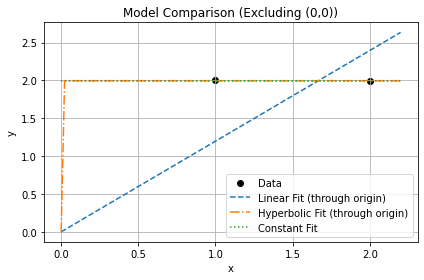

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Original raw data
x_raw = np.array([0, 1, 1, 2, 2])
y_raw = np.array([0, 2, 2, 1.99, 2])

# 1. OMIT (0, 0)
mask = ~((x_raw == 0) & (y_raw == 0))
x_clean = x_raw[mask]
y_clean = y_raw[mask]

# 2. Average y-values per unique x
unique_x = sorted(set(x_clean))
x_data = np.array(unique_x)
y_data = np.array([np.mean(y_clean[x_clean == x]) for x in unique_x])

# 3. Define models
def linear_model(x, a):
    return a * x

def hyperbolic_model(x, a, b):
    return a * x / (b + x)

def constant_model(x, a):
    return a * np.ones_like(x)

# 4. Fit models (linear and hyperbolic forced through origin by definition)
popt_lin, _ = curve_fit(linear_model, x_data, y_data)
popt_hyp, _ = curve_fit(hyperbolic_model, x_data, y_data, bounds=([0, 0], [np.inf, np.inf]))

# 5. Constant model (not constrained to origin)
popt_const, _ = curve_fit(constant_model, x_data, y_data)

# 6. Predictions and residuals
y_pred_lin = linear_model(x_data, *popt_lin)
y_pred_hyp = hyperbolic_model(x_data, *popt_hyp)
y_pred_const = constant_model(x_data, *popt_const)

rss_lin = np.sum((y_data - y_pred_lin) ** 2)
rss_hyp = np.sum((y_data - y_pred_hyp) ** 2)
rss_const = np.sum((y_data - y_pred_const) ** 2)

# 7. AIC/BIC
def compute_aic(n, rss, k, epsilon=1e-10):
    rss = max(rss, epsilon)
    return n * np.log(rss / n) + 2 * k

def compute_bic(n, rss, k, epsilon=1e-10):
    rss = max(rss, epsilon)
    return n * np.log(rss / n) + k * np.log(n)

n = len(x_data)
aic_lin = compute_aic(n, rss_lin, k=1)
bic_lin = compute_bic(n, rss_lin, k=1)
aic_hyp = compute_aic(n, rss_hyp, k=2)
bic_hyp = compute_bic(n, rss_hyp, k=2)
aic_const = compute_aic(n, rss_const, k=1)
bic_const = compute_bic(n, rss_const, k=1)

# 8. Output
print("Linear model y=ax, a =", popt_lin)
print("Hyperbolic model y=ax/(b+x), a, b =", popt_hyp)
print("Constant model, y=a, a =", popt_const)
print(f"RSS - Linear: {rss_lin:.4f}, Hyperbolic: {rss_hyp:.4f}, Constant: {rss_const:.4f}")
print(f"AIC - Linear: {aic_lin:.2f}, Hyperbolic: {aic_hyp:.2f}, Constant: {aic_const:.2f}")
print(f"BIC - Linear: {bic_lin:.2f}, Hyperbolic: {bic_hyp:.2f}, Constant: {bic_const:.2f}")

# 9. Plot
x_plot = np.linspace(0, max(x_data) * 1.1, 100)
plt.scatter(x_data, y_data, color='black', label='Data')
plt.plot(x_plot, linear_model(x_plot, *popt_lin), '--', label='Linear Fit (through origin)')
plt.plot(x_plot, hyperbolic_model(x_plot, *popt_hyp), '-.', label='Hyperbolic Fit (through origin)')
plt.plot(x_plot, constant_model(x_plot, *popt_const), ':', label='Constant Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Comparison (Excluding (0,0))')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

